In [171]:
import numpy as np
import tensorflow as tf


def get_residual_distribution(model, t_data):
	"""
	Takes autoencoder and (transformed) training data and computes all residuals 
	args: 
		model: keras model for computing reconstructions 
		(k, m, m, 1) -> (k, m, m, 1)

		t_data: numpy array of transformed training data with shape 
		np.shape(t_data) = (N, l, m, m, 1) = (N, 120, 64, 64 ,1)

	returns: residuals, a numpy array of shape (N, l, 1) = (N*120, 1),
		     containing residuals Res_k = ||x_or - x_rc||_2
	"""

	N = np.shape(t_data)[0]
	l = 120
	m = 64

	residuals = np.zeros((N*l,1))
	all_t_images = np.reshape(t_data, (N*l, 64, 64, 1))
	rc = model.predict(all_t_images)

	residuals = np.linalg.norm(all_t_images - rc, axis = (1,2))

	return residuals

def classify_ts_residuals(model, data, q99):
	""" data should shape (N, l, m, m, 1) = (N, 120, 64, 64 ,1)
	# model should be autoencoder (m, m, 1) -> (m, m, 1)
	returns residuals: np array of shape (N, l, 1) = (N, 120, 1)
			containing residual of each reconstruction in the series
			anomalous: binary array which is 0 if the max residual
			is below the 99th percentile, and 1 otherwise.
	"""
	N = np.shape(data)[0]
	l = 120
	m = 64
	residuals = np.zeros((N, l, 1))
	anomalous = np.zeros(N)
	
	for i in range(N):
		seq = data[i]
		rc = model.predict(seq)
		# compute individual residuals in (120, 1) array:
		residuals[i] = np.linalg.norm(np.reshape(seq - rc, (l, m**2, 1)), axis = 1)

		if max(residuals[i]) > q99:
			anomalous[i] = 1

	return residuals, anomalous

def get_residual_distribution_1D(model, t_data):
	"""
	Takes autoencoder and (transformed) training data and computes all residuals 
	args: 
		model: keras model for computing reconstructions 
		(k, m, 1) -> (k, m, 1)

		t_data: numpy array of transformed training data with shape 
		np.shape(t_data) = (N, l, m, 1) = (N, 120, 512, 1)

	returns: residuals, a numpy array of shape (N, l, 1) = (N*120, 1),
		     containing residuals Res_k = ||x_or - x_rc||_2
	"""

	N = np.shape(t_data)[0]
	l = 120
	m = 512

	residuals = np.zeros((N*l,1))
	all_t_images = np.reshape(t_data, (N*l, m, 1))
	rc = model.predict(all_t_images)

	residuals = np.linalg.norm(all_t_images - rc, axis = 1)

	return residuals

def classify_ts_residuals_1D(model, data, q99):
	""" data should shape (N, l, m, 1) = (N, 120, 512, 1)
	# model should be autoencoder (m, 1) -> (m, 1)
	returns residuals: np array of shape (N, l, 1) = (N, 120, 1)
			containing residual of each reconstruction in the series
			anomalous: binary array which is 0 if the max residual
			is below the 99th percentile, and 1 otherwise.
	"""
	N = np.shape(data)[0]
	l = 120
	m = 512
	residuals = np.zeros((N, l, 1))
	anomalous = np.zeros(N)
	
	for i in range(N):
		seq = data[i]
		rc = model.predict(seq)
		# compute individual residuals in (120, 1) array:
		residuals[i] = np.linalg.norm(seq-rc, axis = 1)

		if max(residuals[i]) > q99:
			anomalous[i] = 1

	return residuals, anomalous

def main():

	# load 2D CAE
	model = tf.keras.models.load_model('tsie_2D_CAE_gs')

	# load training data & construct labels (no anomalous sequences)
	gs_p1_t_data = np.reshape(np.load('../airbus_data/gs_p1_t_data.npy'), (1677, 120, 64, 64, 1))

	# compute reconstructions and residuals
	residuals = get_residual_distribution(model, gs_p1_t_data)

	q99 = np.percentile(residuals, 99)
    
	np.save('residual_data/gs_p1_t_residuals.npy',residuals)

	# load validation data & construct labels (half normal, half anomalous)
	gs_p1_v_data = np.reshape(np.load('../airbus_data/gs_p1_v_data.npy'), (594, 120, 64, 64, 1))
    df = pd.read_csv('../airbus_data/dfvalid_groundtruth.csv')
    v_labels = np.array(df['anomaly'])
    
	v_residuals, anomalous = classify_ts_residuals(model, gs_p1_v_data, q99)

	accuracy = np.sum(np.abs(anomalous - v_labels))

In [127]:
# load 2D CAE
model = tf.keras.models.load_model('tsie_2D_CAE_gs')

# load training data & construct labels (no anomalous sequences)
gs_p1_t_data = np.reshape(np.load('../airbus_data/gs_p1_t_data.npy'), (1677, 120, 64, 64, 1))

In [5]:
import time

In [43]:
# compute reconstructions and residuals
t0 = time.time()
residuals = get_residual_distribution(model, gs_p1_t_data)
print('time elapsed is : ', time.time() - t0)

time elapsed is :  914.9418170452118


In [44]:
np.shape(residuals)

(201240, 1)

In [45]:
np.save('residual_data/gs_p1_t_residuals.npy',residuals)

In [280]:
q99 = np.percentile(residuals, 99)

In [281]:
print('99th percentile is: ', q99)

99th percentile is:  1.5801852684855482


In [282]:
# check to see if this is accurate:
sum(residuals > q99)/len(residuals)

array([0.01000298])

In [50]:
# now classify validation data via this quantile threshold:
gs_p1_v_data = np.reshape(np.load('../airbus_data/gs_p1_v_data.npy'), (594, 120, 64, 64, 1))
df = pd.read_csv('../airbus_data/dfvalid_groundtruth.csv')
v_labels = np.array(df['anomaly'])
v_residuals, anomalous = classify_ts_residuals(model, gs_p1_v_data, q99)

In [283]:
accuracy = 1 - (np.sum(np.abs(anomalous - v_labels))) / len(v_labels)
print('accuracy is: ', accuracy)

accuracy is:  0.7744107744107744


In [284]:
TPR = sum((anomalous + v_labels == 2))/297
FPR = sum(v_labels - anomalous == -1 )/297
print(TPR)
print(FPR)

0.5488215488215489
0.0


In [285]:
# read in raw data for 1D CAE no decoding baseline
import pandas as pd
t_data = np.array(np.reshape(np.array(pd.read_hdf('../airbus_data/dftrain.h5')), (1677, 120, 512, 1)))
v_data = np.array(np.reshape(np.array(pd.read_hdf('../airbus_data/dfvalid.h5')), (594, 120, 512, 1)))

In [170]:
CAE_1D = tf.keras.models.load_model('tsie_1D_CAE')

In [191]:
# compute reconstructions and residuals
t0 = time.time()
residuals_1D = get_residual_distribution_1D(CAE_1D, t_data)
print('time elapsed is : ', time.time() - t0)

time elapsed is :  119.62963581085205


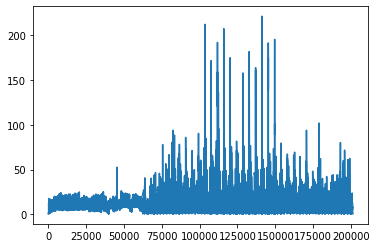

In [192]:
plt.plot(residuals_1D)

In [286]:
np.save('residual_data/t_residuals_1D.npy',residuals_1D)
q99_1D = np.percentile(residuals_1D, 99)
print('99th percentile is: ', q99_1D)

99th percentile is:  58.94001822524485


In [287]:
# now classify validation data via this quantile threshold:
# df = pd.read_csv('../airbus_data/dfvalid_groundtruth.csv')
# v_labels = np.array(df['anomaly'])

# v_residuals_1D, anomalous_1D = classify_ts_residuals_1D(CAE_1D, v_data, q99_1D)

accuracy_1D = 1 - (np.sum(np.abs(anomalous_1D - v_labels))) / len(v_labels)
print('accuracy is: ', accuracy_1D)

accuracy is:  0.8400673400673401


In [288]:
TPR_1D = sum(anomalous_1D + v_labels == 2)/297
FPR_1D = sum(v_labels - anomalous_1D == -1)/297

print('TPR is: ', TPR_1D)
print('FPR is: ', FPR_1D)

TPR is:  0.6801346801346801
FPR is:  0.0
